<a href="https://colab.research.google.com/github/Denisganga/ImageClassificationModel/blob/main/image_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt #for plotting
import numpy as np # for transformation

import torch #pytorch package
import torchvision#load datasets
import torchvision.transforms as transforms #transform data
import torch.nn as nn #basic building block for neural networks
import torch.nn.functional as F #import convolution functions like Relu
import torch.optim as optim #optimizer

In [2]:
#python image library of range [0,1]
#transform them to tensors of normalized range[-1,1]

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

#set batch_size
batch_size = 4

#set number of workers
num_workers= 2


#load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader =torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True,num_workers=num_workers)

#load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

#put 10 classes into a set
classes =('plane','car','bird','cat',
          'deer','dog','frog','horse','ship','truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 66136756.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


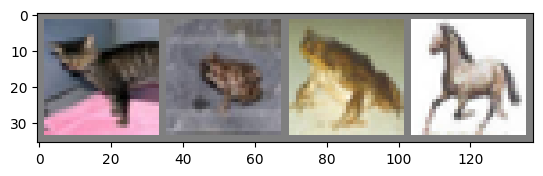

Class labels for each image in the batch:
cat frog frog horse


In [3]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    ''' Function to show image '''
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of random training images with a for loop
for images, labels in trainloader:
    # Call the function on our images and display them
    imshow(torchvision.utils.make_grid(images))

    # Print the class labels for each image in the batch
    print("Class labels for each image in the batch:")
    print(' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

    # Break the loop to display only one batch of images (remove this line if you want to see multiple batches)
    break



In [4]:
#Now its time to build our network

class Net(nn.Module):
  ''' Models a simple Convolutional Neural Network'''
  def __init__(self):
    ''' initialize the network '''
    super(Net, self).__init__()
    #3 input image channel, 6 output channels,
    #5*5 square convolution kernel
    self.conv1=nn.Conv2d(3, 6, 5)

    #Max pooling over a (2, 2) window
    self.pool=nn.MaxPool2d(2, 2)
    self.conv2=nn.Conv2d(6, 16, 5)
    self.fc1=nn.Linear(16 * 5 * 5, 120 )#5*5 from image dimension
    self.fc2=nn.Linear(120, 84)
    self.fc3=nn.Linear(84,10)

  def forward(self, x):
    ''' the forward propagation algorithm '''
    x= self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    x= x.view(-1, 16 * 5* 5)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
#define a loss function optmizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
#train the network
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):#loop over the dataset ,multiple times

  running_loss =0.0
  for i,data in enumerate(trainloader, 0):
    #get the inputs; data is a list of [inputs,labels]
    inputs, labels =data

    #zero the parameter gradients
    optimizer.zero_grad()

    #forward+backword+optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss +=loss.item()
    if i % 2000 ==1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch +1, i+1, running_loss /2000))
      running_loss = 0.0

end.record()

torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

[1,  2000] loss: 2.208
[1,  4000] loss: 1.917
[1,  6000] loss: 1.690
[1,  8000] loss: 1.597
[1, 10000] loss: 1.507
[1, 12000] loss: 1.486
[2,  2000] loss: 1.424
[2,  4000] loss: 1.354
[2,  6000] loss: 1.343
[2,  8000] loss: 1.332
[2, 10000] loss: 1.315
[2, 12000] loss: 1.274
Finished Training
126854.234375


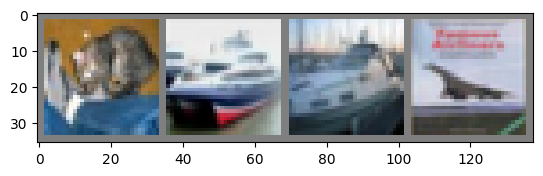

GroundTruth:  cat ship ship plane


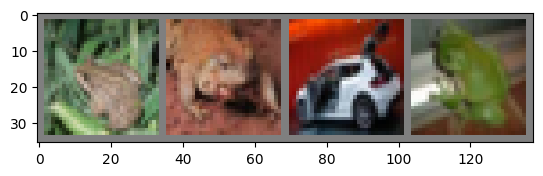

GroundTruth:  frog frog car frog


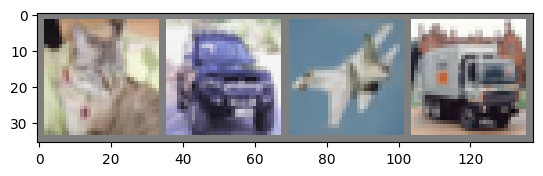

GroundTruth:  cat car plane truck


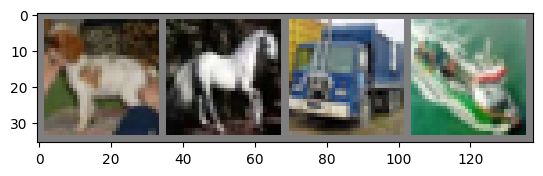

GroundTruth:  dog horse truck ship


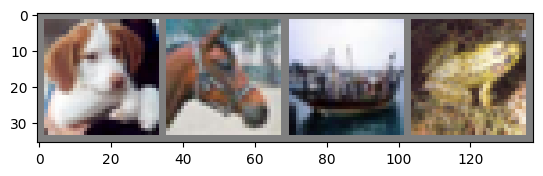

GroundTruth:  dog horse ship frog


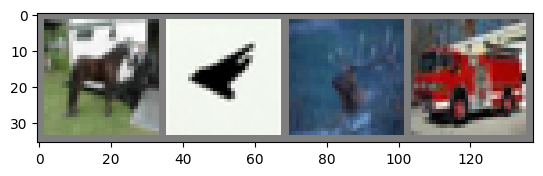

GroundTruth:  horse plane deer truck


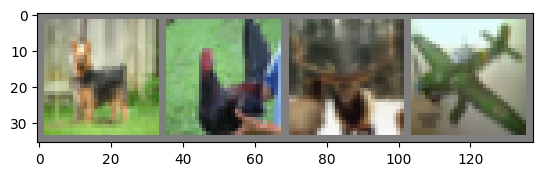

GroundTruth:  dog bird deer plane


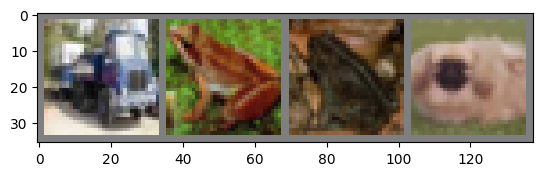

GroundTruth:  truck frog frog dog


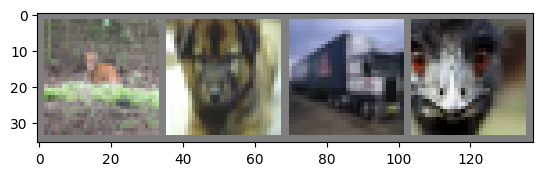

GroundTruth:  deer dog truck bird


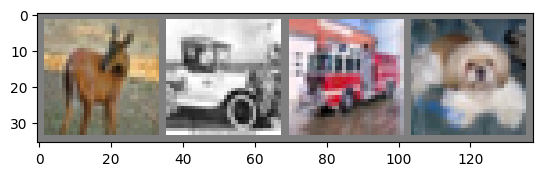

GroundTruth:  deer car truck dog


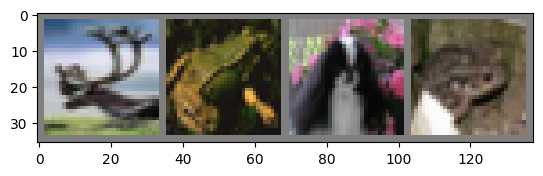

GroundTruth:  deer frog dog frog


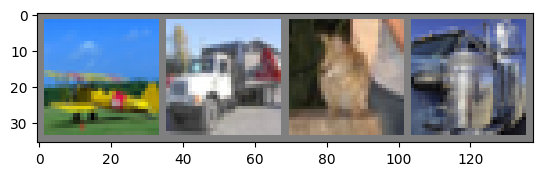

GroundTruth:  plane truck cat truck


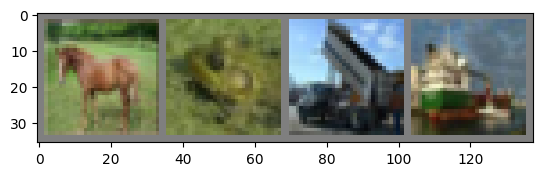

GroundTruth:  horse frog truck ship


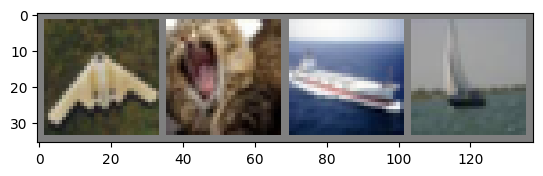

GroundTruth:  plane cat ship ship


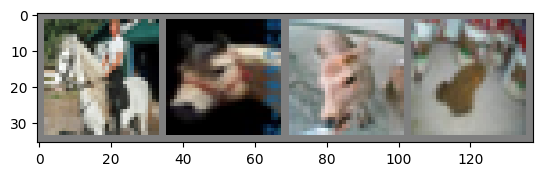

GroundTruth:  horse horse deer frog


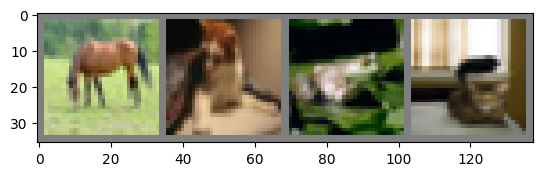

GroundTruth:  horse cat frog cat


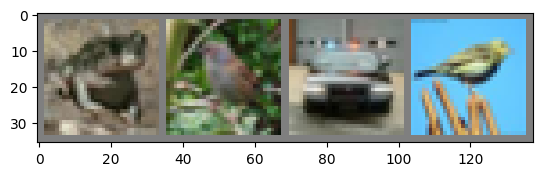

GroundTruth:  frog bird car bird


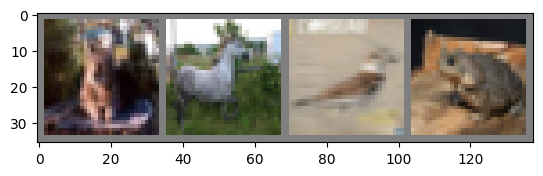

GroundTruth:  cat horse bird frog


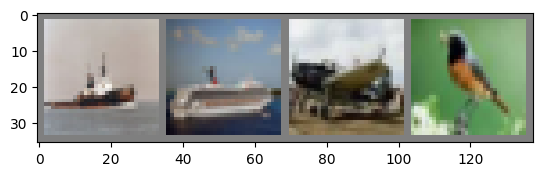

GroundTruth:  ship ship plane bird


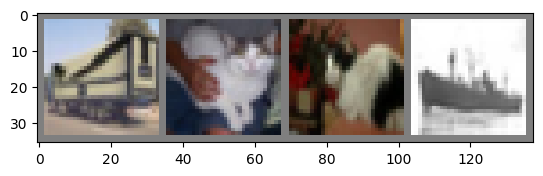

GroundTruth:  truck cat cat ship


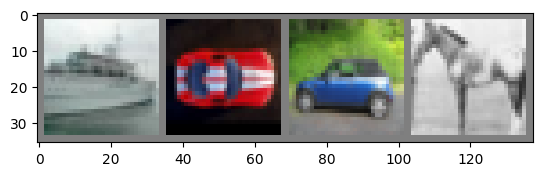

GroundTruth:  ship car car horse


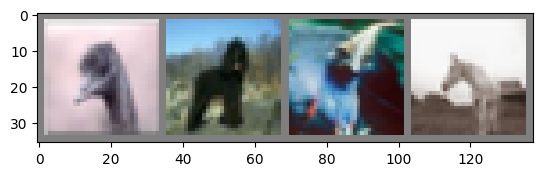

GroundTruth:  bird dog bird horse


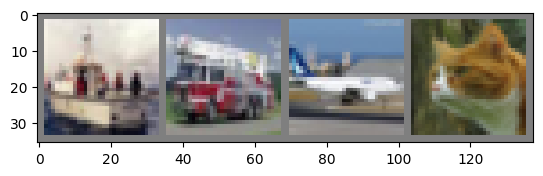

GroundTruth:  ship truck plane cat


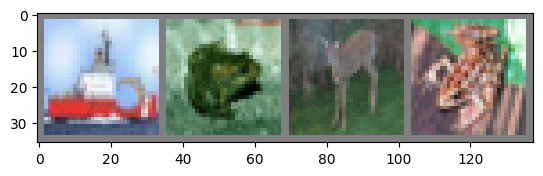

GroundTruth:  ship frog deer frog


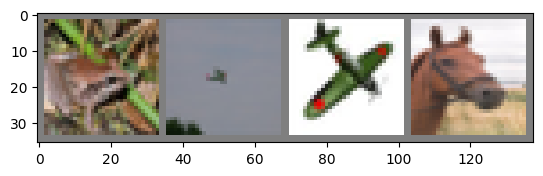

GroundTruth:  frog plane plane horse


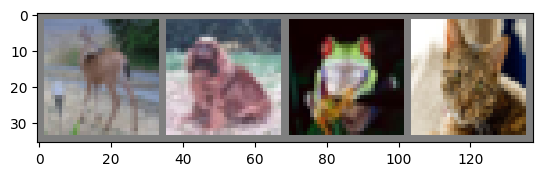

GroundTruth:  deer dog frog cat


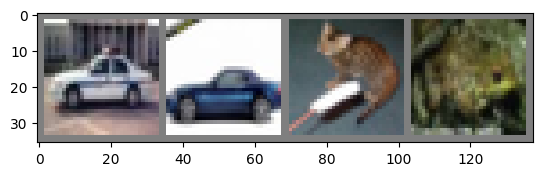

GroundTruth:  car car cat frog


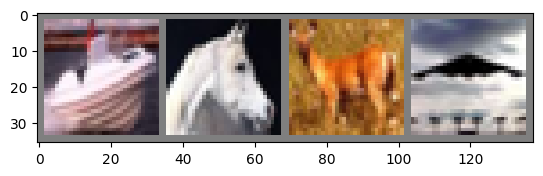

GroundTruth:  ship horse deer plane


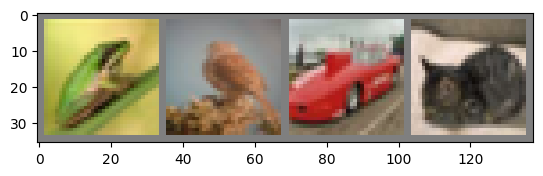

GroundTruth:  frog bird car cat


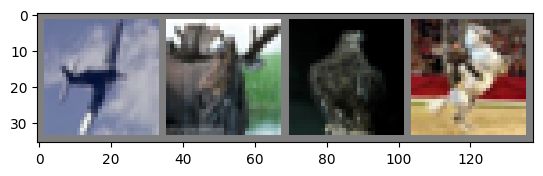

GroundTruth:  plane deer bird horse


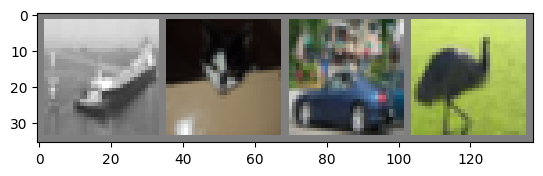

GroundTruth:  ship cat car bird


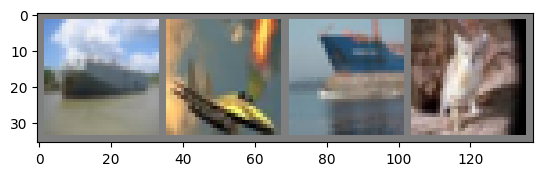

GroundTruth:  ship plane ship cat


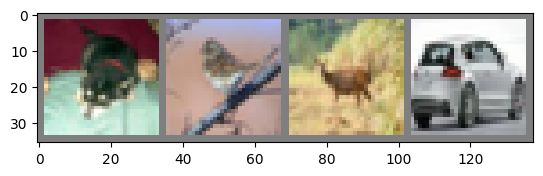

GroundTruth:  dog bird deer car


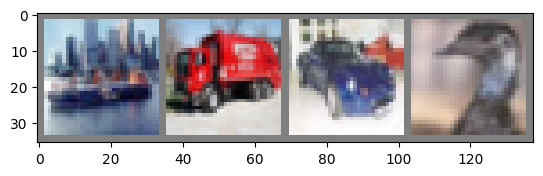

GroundTruth:  ship truck car bird


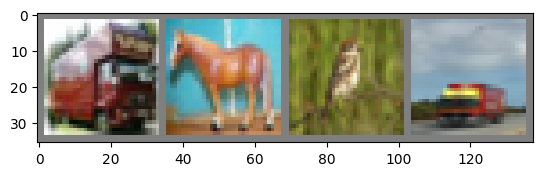

GroundTruth:  truck horse bird truck


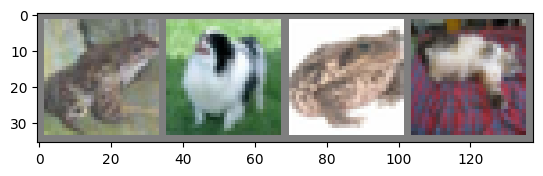

GroundTruth:  frog dog frog cat


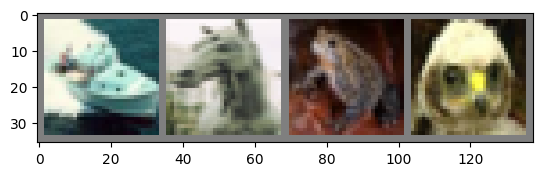

GroundTruth:  ship horse frog bird


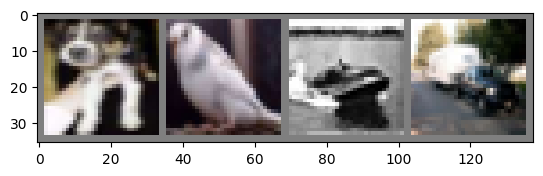

GroundTruth:  dog bird ship truck


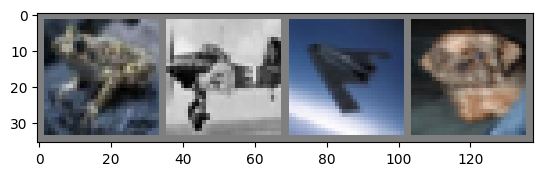

GroundTruth:  frog plane plane dog


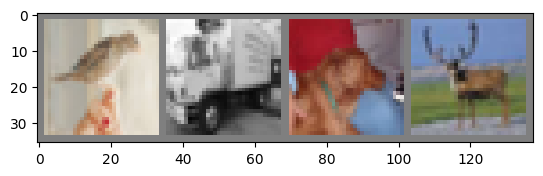

GroundTruth:  bird truck dog deer


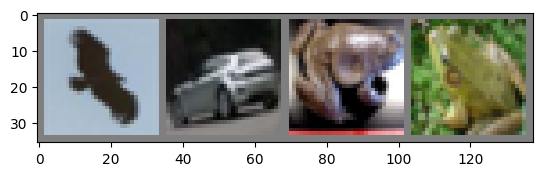

GroundTruth:  bird car frog frog


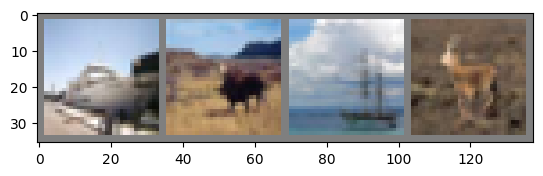

GroundTruth:  ship deer ship deer


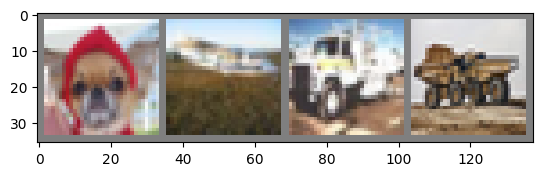

GroundTruth:  dog plane truck truck


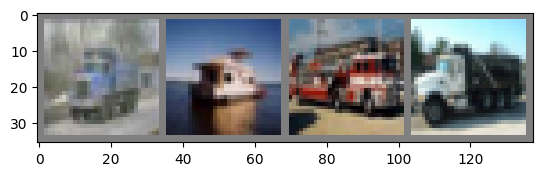

GroundTruth:  truck ship truck truck


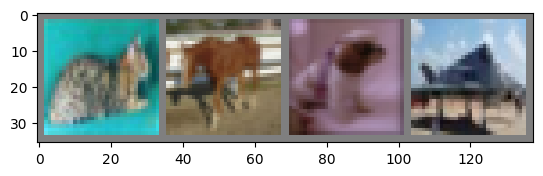

GroundTruth:  cat horse dog plane


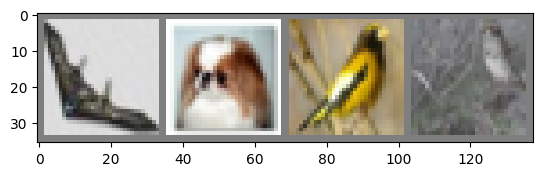

GroundTruth:  plane dog bird bird


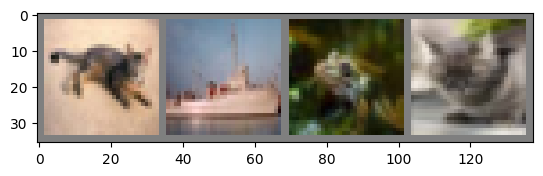

GroundTruth:  cat ship frog cat


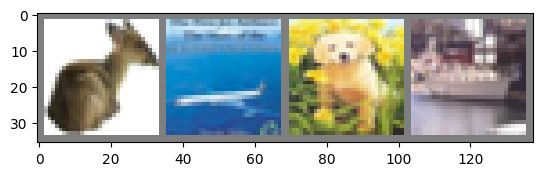

GroundTruth:  deer plane dog ship


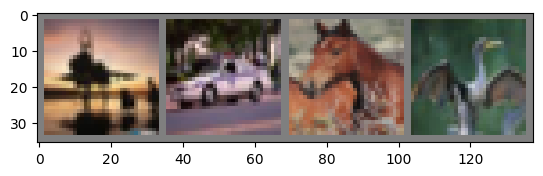

GroundTruth:  plane car horse bird


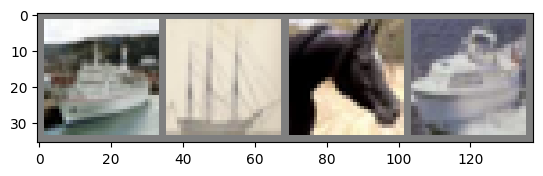

GroundTruth:  ship ship horse ship


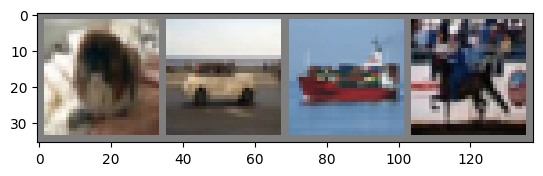

GroundTruth:  dog car ship horse


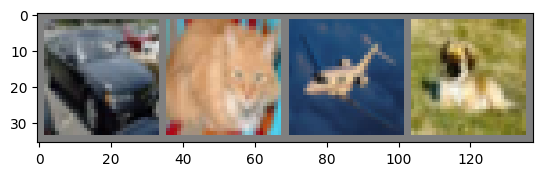

GroundTruth:  car cat plane dog


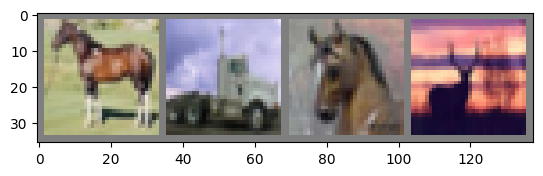

GroundTruth:  horse truck horse deer


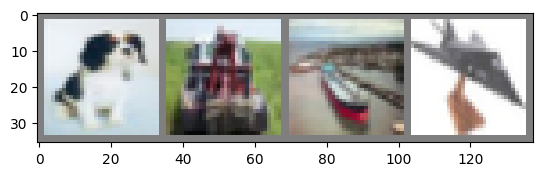

GroundTruth:  dog truck ship plane


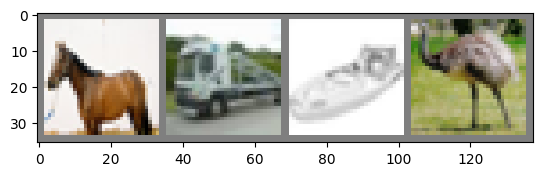

GroundTruth:  horse truck ship bird


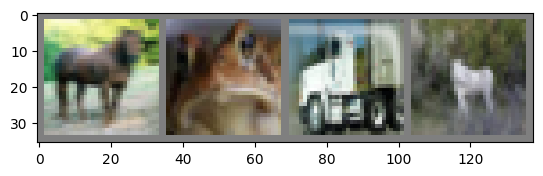

GroundTruth:  horse frog truck deer


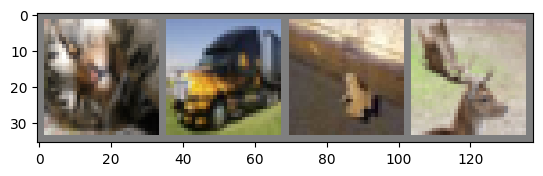

GroundTruth:  cat truck frog deer


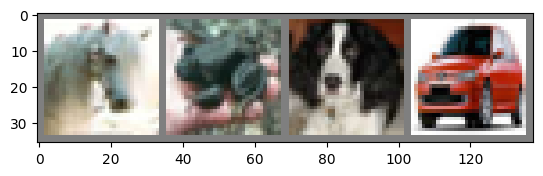

GroundTruth:  horse frog dog car


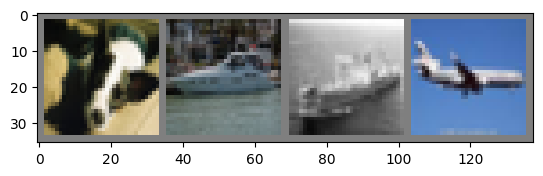

GroundTruth:  dog ship ship plane


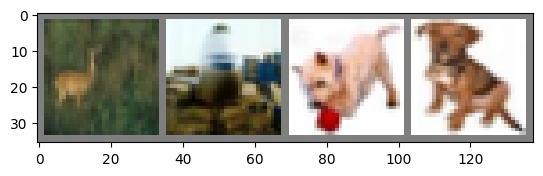

GroundTruth:  deer plane dog dog


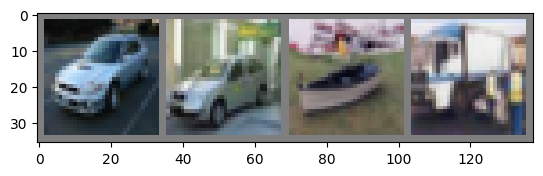

GroundTruth:  car car ship truck


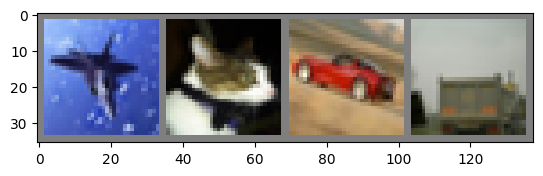

GroundTruth:  plane cat car truck


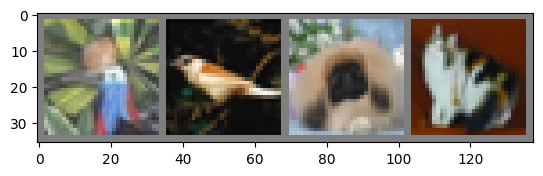

GroundTruth:  bird bird dog cat


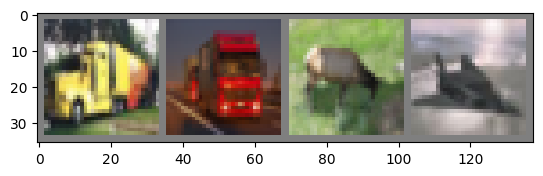

GroundTruth:  truck truck deer plane


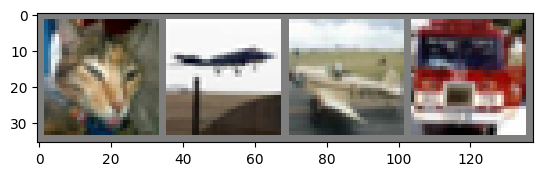

GroundTruth:  cat plane plane truck


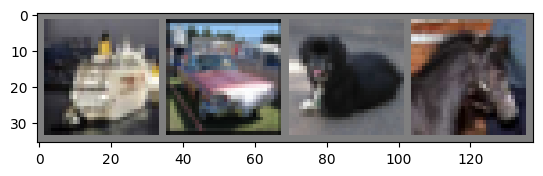

GroundTruth:  ship car dog horse


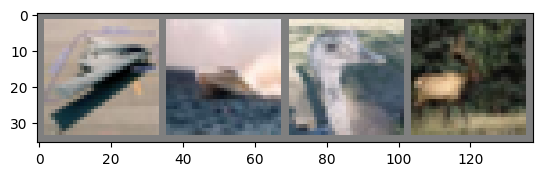

GroundTruth:  plane ship bird deer


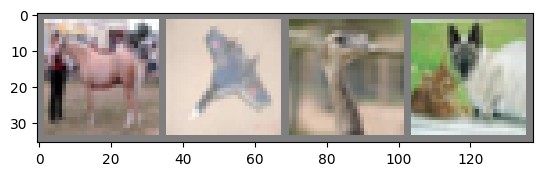

GroundTruth:  horse plane bird cat


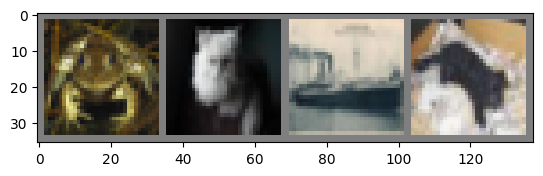

GroundTruth:  frog cat ship dog


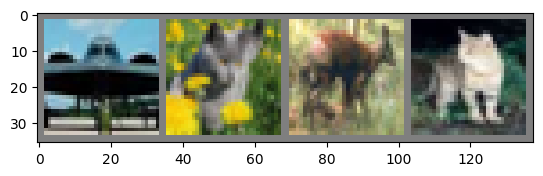

GroundTruth:  plane cat deer cat


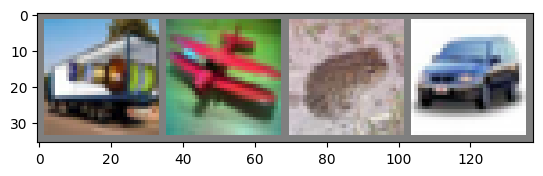

GroundTruth:  truck plane frog car


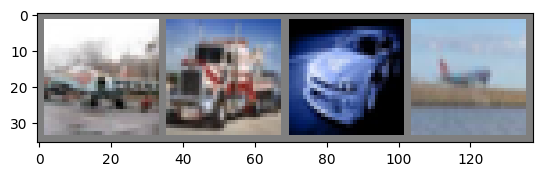

GroundTruth:  plane truck car plane


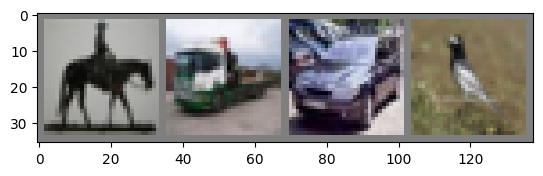

GroundTruth:  horse truck car bird


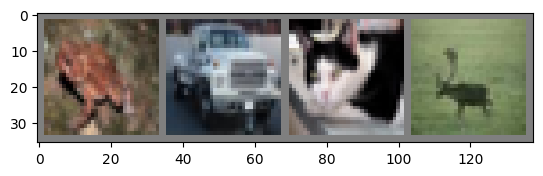

GroundTruth:  frog truck cat deer


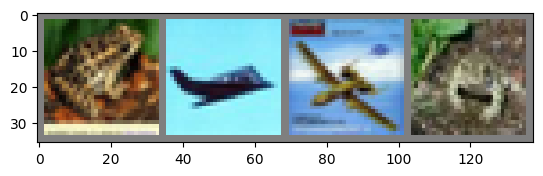

GroundTruth:  frog plane plane frog


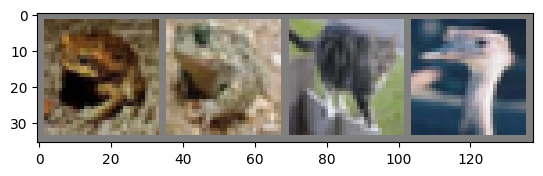

GroundTruth:  frog frog cat bird


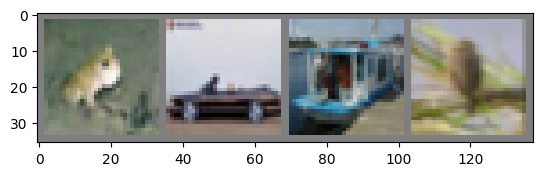

GroundTruth:  frog car ship bird


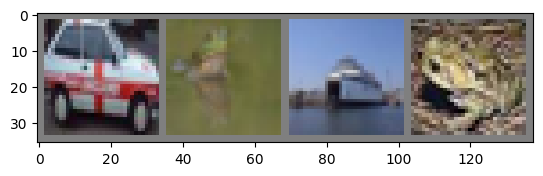

In [ ]:
for images, labels in testloader:
    # Your code for processing the batch of images and labels goes here
    # For example, you can visualize the images like this:
    imshow(torchvision.utils.make_grid(images))
    plt.show()
    print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))